# Setup and Install Dependencies


### Install necessary libraries


In [ ]:
!pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0 torch torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━

### Import Libraries

In [ ]:
import torch
from torch import nn, optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset
from diffusers import DDPMScheduler, DDPMPipeline, UNet2DModel
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


### Setting device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load and Downsample Dataset


### Load the flowers dataset


In [ ]:
dataset = load_dataset("huggan/flowers-102-categories", split="train")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8189 [00:00<?, ? examples/s]

### Define a transform to downsample the images


In [ ]:
image_size = 32

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


### Apply the transform to the dataset


In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

# def transform(examples):
#     processed_images = []
#     for image in examples["image"]:
#         if isinstance(image, list):  # If image is a list, convert to a numpy array
#             image = np.array(image, dtype=np.uint8)
#         if isinstance(image, np.ndarray):  # If image is a NumPy array, convert to a PIL Image
#             if image.ndim == 3 and image.shape[0] in {1, 3}:  # Check for (channels, height, width) format
#                 image = np.transpose(image, (1, 2, 0))  # Convert to (height, width, channels) format
#             image = Image.fromarray(image)
#         elif not isinstance(image, Image.Image):  # Catch all other types that aren't already PIL Images
#             raise ValueError(f"Unexpected image type: {type(image)}")
#         # Convert to RGB and apply preprocessing
#         image = preprocess(image.convert("RGB"))
#         processed_images.append(image)
#     return {"image": processed_images}  # Return with the key 'image'


dataset.set_transform(transform)


# Prepare the Data for Training


### Create a DataLoader


In [ ]:
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


### Visualize some training images


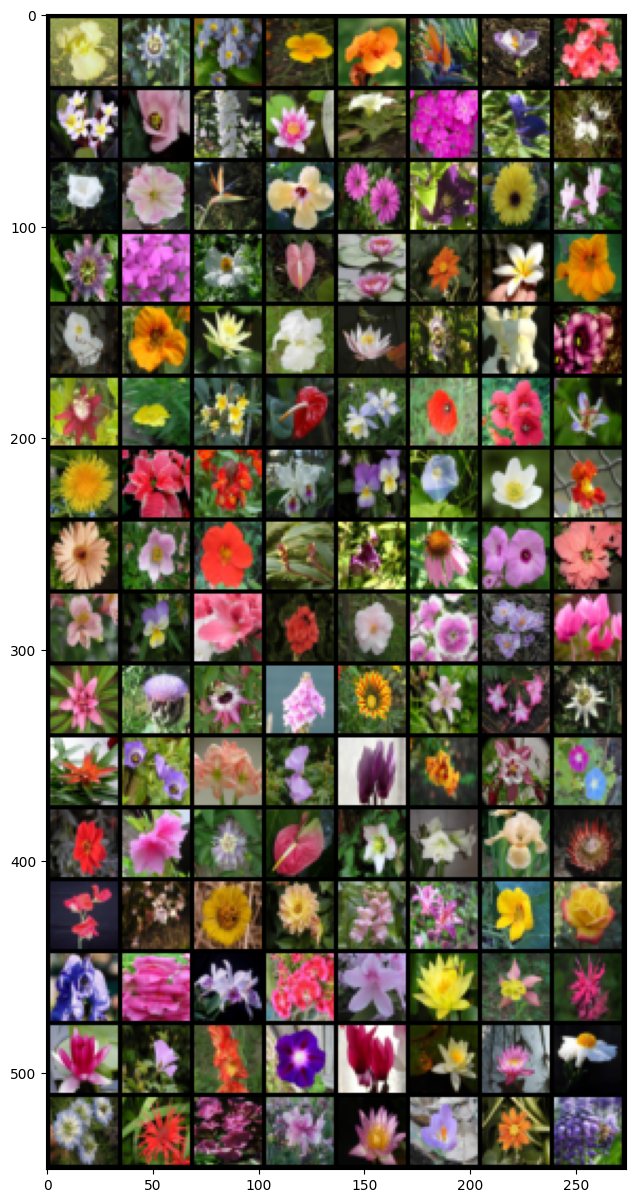

In [ ]:
def visualize_training_images():
    sample_batch = next(iter(dataloader))
    sample_images = sample_batch['images']
    sample_images = (sample_images + 1) / 2  # Denormalize to [0, 1]

    grid_img = torchvision.utils.make_grid(sample_images, nrow=8)
    plt.figure(figsize=(15,15))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()


visualize_training_images()


### Functions for convert to PIL and easy viewing

In [ ]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


### grab a batch of images and view some of them

X shape: torch.Size([8, 3, 32, 32])


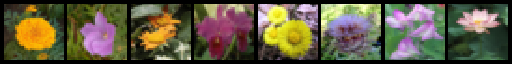

In [ ]:
xb = next(iter(dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)


# Define the Diffusion Model


### Create a model

In [ ]:
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);


# Train the Model


### Define loss function and optimizer


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=4e-4)


### Scheduler for diffusion process


In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")


### Training loop


In [ ]:
epochs = 20
losses = []

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = criterion(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 4 == 0:
        loss_last_epoch = sum(losses[-len(dataloader) :]) / len(dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")


Epoch:4, loss: 0.10705247800797224
Epoch:8, loss: 0.09886355837807059
Epoch:12, loss: 0.09324508532881737
Epoch:16, loss: 0.08870526461396366
Epoch:20, loss: 0.08735094458097592


### Log Loss plot

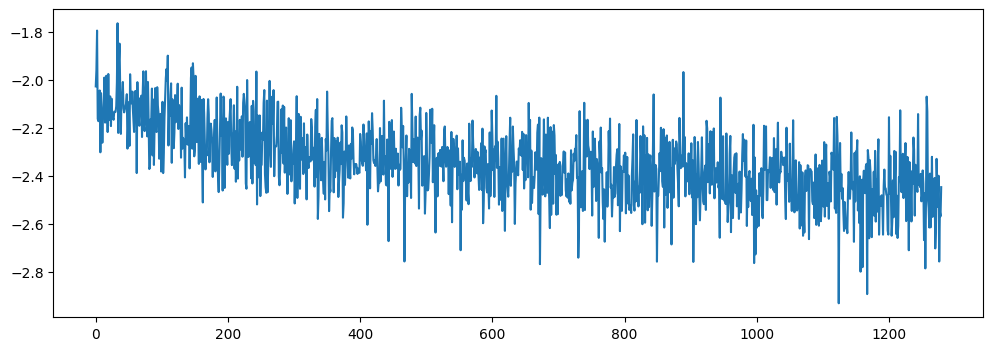

In [ ]:
fig, axs = plt.subplots(1, figsize=(12, 4))
axs.plot(np.log(losses))
plt.show()


# Save and Evaluate the Model

### Save the model


In [ ]:
torch.save(model.state_dict(), "simple_unet.pth")


### Load the model for evaluation


In [ ]:
model.load_state_dict(torch.load("simple_unet.pth"))
model.eval()


UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

### Define a pipeline

In [ ]:
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)


### Generate images


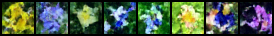

In [ ]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, image_size, image_size).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)